# Simulation Study
Here we simulate GARCHX processes with varying parameters, fit both GARCH and GARCH-X model, and compare 
1. MSE of volatility $\sigma_t^2$,
2. Log likelihood values evaluated at the MLE,
3. convergence of estimated parameter values.

In [2]:
import random
import itertools

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
#! pip install seaborn
import seaborn as sns

sns.set_theme()
sns.set_style('darkgrid')

from tqdm import tqdm
from arch import arch_model

from Garch import GARCH

## 1. Define DGP functions and helper functions.

In [51]:
def generate_ARMA_data(ar_coef: np.ndarray, ma_coef: np.ndarray, T: int) -> np.ndarray:
    p = len(ar_coef)
    q = len(ma_coef)
    
    res = np.zeros(T) 
    errors = np.random.normal(0, 1, T)  

    for t in range(max(p, q), T):
        ar_part = np.sum(ar_coef * res[t-p: t]) if p > 0 else 0
        ma_part = np.sum(ma_coef * errors[t-q: t]) if q > 0 else 0

        res[t] = ar_part + ma_part + errors[t]

    return res

In [52]:
def generate_GARCH_data(omega: float, alpha: float, beta: float, gamma: float, T: int = 1000, x=None):
    if x is not None:
        assert x.shape[0] == T, ValueError("Length of x should be T.")

    e = np.zeros(T)
    sigma2 = np.zeros(T)
    
    sigma2[0] = 1  
    e[0] = np.random.normal(0, 1)


    for t in range(1, T): 
        if x is None:
            sigma2[t] = omega + alpha * e[t-1]**2 + beta * sigma2[t-1] 
        else: 
            sigma2[t] = omega + alpha * e[t-1]**2 + beta * sigma2[t-1] + gamma * x[t]**2 
        e[t] = np.random.normal(0, np.sqrt(sigma2[t]))

    return e, sigma2

In [53]:
from scipy.stats import chi2

def likelihood_ratio_test(ll_null: float, ll_alternative: float, df: int):

    if df <= 0:
        raise ValueError("Degrees of freedom must be positive.")
    
    # Compute test statistic
    lr_stat = 2 * (ll_alternative - ll_null)
    
    # Compute p-value
    p_value = 1 - chi2.cdf(lr_stat, df)
    
    return p_value

In [54]:
def mse(arr1, arr2):
    if len(arr1) != len(arr2):
        return False
    return np.sum(np.square(np.array(arr1) - np.array(arr2))) / len(arr1)

## 2. Conduct one simulation 

#### 2.1. Generate synthetic data. x can be set with any ARMA(p, q) sepcification

In [55]:
T = 1200

# Generate exo
np.random.seed(69)
x = generate_ARMA_data([], [], T)

params = (0.1, 0.1, 0.2, 0.25)  # (omega, alpha, beta, gamma)
e, sigma2 = generate_GARCH_data(*params, T, x)

#### 2.2 Fit both models. Returns $e$ is scaled by $s=10$ for convergence of optimisation; Later, sigma needs to be scaled down by $s^2=100$.

In [56]:
# Fit without exogenous 
garch_without_exo = GARCH(p=1, q=1, z=0)
garch_without_exo.train(10*e, method='SLSQP', use_constraints=True)

garch_without_exo.summary()

d:\Programming\sentiment-analysis-volatility-forecasting-1\notebooks\Garch.py:242: RuntimeWarning: invalid value encountered in log
  avg_log_like += (np.log(sigma2[t]) + (e[t] ** 2) / sigma2[t]) / self.n_obs


,coef,std err,t,P>|t|
omega,13.096936,4.273951,3.064363,1.115064e-03
alpha,0.126698,0.032656,3.879713,5.513819e-05
beta,0.608598,0.105427,5.772676,4.965624e-09


In [57]:
garch_with_exo = GARCH(p=1, q=1, z=1)
garch_with_exo.train(10*e, x=np.array(x), method='SLSQP', use_constraints=True)

garch_with_exo.summary()

,coef,std err,t,P>|t|
omega,12.051503,2.792755,4.315274,8.628207e-06
alpha,0.071773,0.026915,2.666694,3.881748e-03
beta,0.210306,0.070071,3.001313,1.371960e-03
gamma[0],22.520574,2.574423,8.747815,3.629334e-18


#### 2.3 Evalaute MSE of $\sigma_t^2$

In [58]:
print(f"GARCH(1,1) MSE: {mse(sigma2, garch_without_exo.sigma2/100)}")
print(f"GARCHX MSE: {mse(sigma2, garch_with_exo.sigma2/100)}")

GARCH(1,1) MSE: 0.12249518228313065
GARCHX MSE: 0.002472980056843917


#### 2.4 Data Visualisation

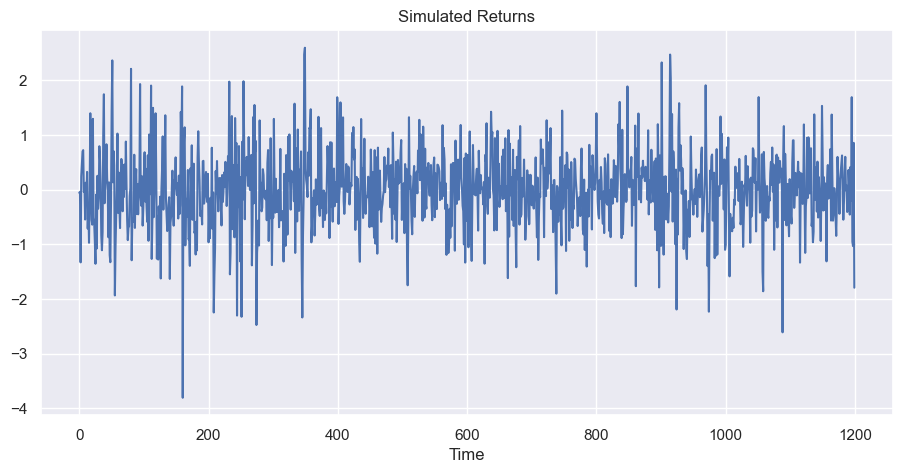

In [59]:
f, axs = plt.subplots(figsize=(11, 5))
plt.plot(e)
plt.xlabel('Time')
plt.title('Simulated Returns')
plt.show()

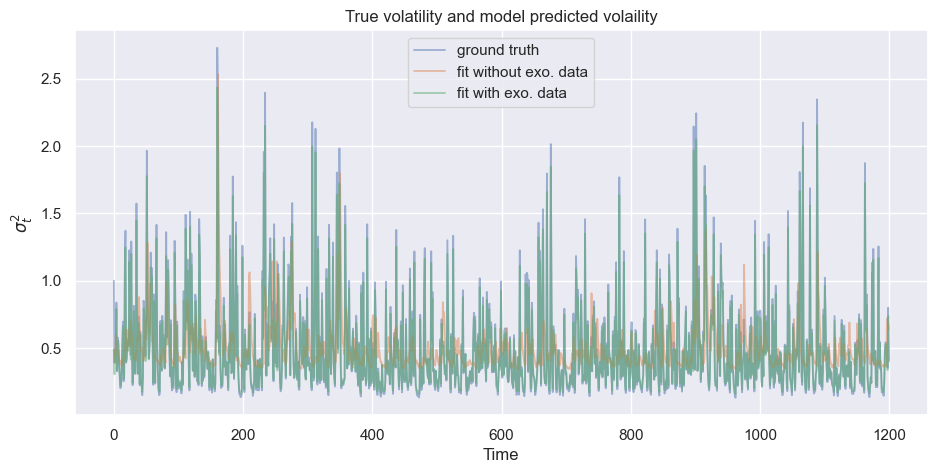

In [60]:
f, axs = plt.subplots(figsize=(11, 5))

plt.plot(sigma2, label='ground truth', alpha=0.5, linewidth=1.3)
plt.plot(garch_without_exo.sigma2/100, label='fit without exo. data', alpha=0.5, linewidth=1.3)
plt.plot(garch_with_exo.sigma2/100, label='fit with exo. data', alpha=0.5, linewidth=1.3)

plt.legend()
plt.title('True volatility and model predicted volaility')
plt.ylabel(r'$\sigma_t^2$')
plt.xlabel('Time')
plt.show()

Here the left plot demonstrates uncorrelatedness of errors and the exogenous variable. The right plot shows how in the GARCHX DGP, volaility is lower bound by $x^2$

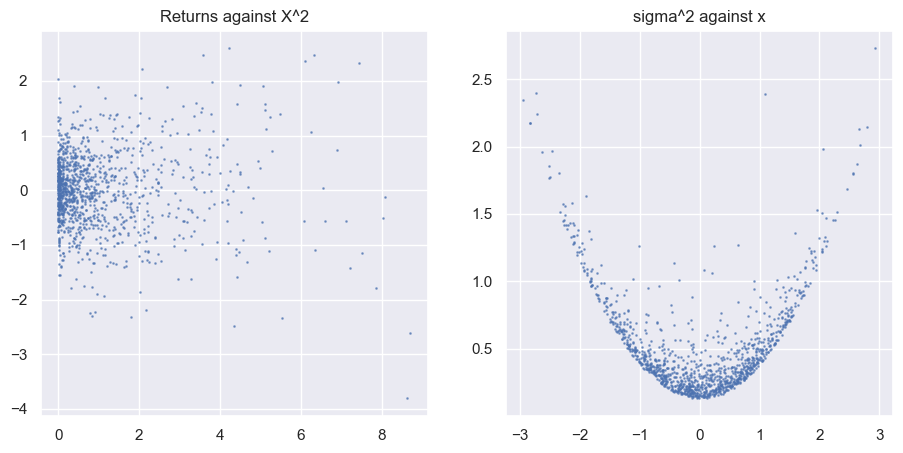

In [69]:
f, axs = plt.subplots(1, 2, figsize=(11, 5))

axs[0].scatter(x**2, e, s=0.9, alpha=0.6)
axs[0].title.set_text('Returns against X^2')
axs[1].scatter(x, sigma2, s=0.9, alpha=0.6)
axs[1].title.set_text('sigma^2 against x')
plt.show()

## 3. Simulation Study
Using a grid of model parameters (see below) to define varying data. For each generated data we fit two models, one without using the exogenous data and another with the exogenous data. We then compare MSE, log likelihood values and estimated parameter values.

In [ ]:
T = 1200
samples = 50

omegas = [0.1]
alphas = [0.1]
betas = [0.2, 0.8]
gammas = [0.02, 0.1, 0.25] 
arma_coefs = [[[], []]]  # iid

In [ ]:
results = []
for params in itertools.product(omegas, alphas, betas, gammas):
    print(params)
    for sample in tqdm(range(samples)):
        for arma_coef in arma_coefs:
            np.random.seed(sample)
            x = generate_ARMA_data(*arma_coef, T)
            e, sigma2 = generate_GARCH_data(*params, T, x)


            if params[2] == 0.8 and (params[3] == 0.1 or params[3] == 0.25):  # Adjust e for optimisation stability.
                scaling_factor = 10
            else:
                scaling_factor = 1
            
            e *= scaling_factor
                
            row_data = [*params, arma_coef, sample]
            
            # Fit normal GARCH model.
            garch_without_exo = GARCH(p=1, q=1, z=0)
            without_exo_opt_success = garch_without_exo.train(e, suppress_warnings=True, use_constraints=True, method='SLSQP')
            model_params = garch_without_exo.omega/(scaling_factor**2), garch_without_exo.alpha, garch_without_exo.beta
            row_data.extend(model_params)

            # Fit GARCHX model
            garch_with_exo = GARCH(p=1, q=1, z=1)
            with_exo_opt_success = garch_with_exo.train(e, x=x, suppress_warnings=True)
            model_params = garch_with_exo.omega/(scaling_factor**2), garch_with_exo.alpha, garch_with_exo.beta, garch_with_exo.gamma[0][0]/(scaling_factor**2)
            row_data.extend(model_params)

            without_exo_MSE = mse(sigma2, garch_without_exo.sigma2/(scaling_factor**2))
            with_exo_MSE = mse(sigma2, garch_with_exo.sigma2/(scaling_factor**2))
            
            row_data.extend([without_exo_MSE, with_exo_MSE, garch_without_exo.loglikelihood, garch_with_exo.loglikelihood,
                               without_exo_opt_success, with_exo_opt_success])
            
            results.append(row_data)


columns = ['omega', 'alpha', 'beta', 'gamma', 'x', 'sample', 'omega_wo_exo', 'alpha_wo_exo', 'beta_wo_exo',
            'omega_with_exo', 'alpha_with_exo', 'beta_with_exo', 'gamma_with_exo', 
            'without_exo_MSE', 'with_exo_MSE', 'without_exo_logll', 'with_exo_logll', 'without_exo_opt_suc', 'with_exo_opt_suc']
result_df = pd.DataFrame(columns=columns, data=results)

(0.1, 0.1, 0.2, 0.02)


 64%|██████▍   | 32/50 [02:20<01:32,  5.14s/it]d:\Programming\sentiment-analysis-volatility-forecasting-1\notebooks\Garch.py:242: RuntimeWarning: invalid value encountered in log
  avg_log_like += (np.log(sigma2[t]) + (e[t] ** 2) / sigma2[t]) / self.n_obs
100%|██████████| 50/50 [03:45<00:00,  4.52s/it]


(0.1, 0.1, 0.8, 0.02)


100%|██████████| 50/50 [05:48<00:00,  6.96s/it]


In [ ]:
result_df.to_csv('../data/simulation_study_results.csv')

# Analysis of Results

In [212]:
result_df = pd.read_csv('../data/simulation_study_results.csv')

In [201]:
result_df

,omega,alpha,beta,gamma,x,sample,omega_wo_exo,alpha_wo_exo,beta_wo_exo,omega_with_exo,alpha_with_exo,beta_with_exo,gamma_with_exo,without_exo_MSE,with_exo_MSE,without_exo_logll,with_exo_logll,without_exo_opt_suc,with_exo_opt_suc
50,0.1,0.1,0.2,0.10,"[[], []]",0,0.221852,0.152041,0.046315,0.087606,0.131806,0.171808,0.107573,0.019665,0.000810,-917.910911,-847.175848,True,True
51,0.1,0.1,0.2,0.10,"[[], []]",1,0.198164,0.176187,0.143336,0.085154,0.117889,0.301665,0.087738,0.022311,0.001192,-946.259084,-908.192047,True,True
52,0.1,0.1,0.2,0.10,"[[], []]",2,0.189208,0.158135,0.190359,0.123347,0.150386,0.051142,0.106654,0.023112,0.001253,-945.275112,-877.875240,True,True
53,0.1,0.1,0.2,0.10,"[[], []]",3,0.158020,0.118297,0.315547,0.107744,0.116337,0.206673,0.077811,0.021623,0.001631,-926.941657,-884.111075,True,True
54,0.1,0.1,0.2,0.10,"[[], []]",4,0.091510,0.059120,0.579548,0.063749,0.063887,0.324421,0.101113,0.019152,0.001211,-875.625921,-820.443598,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.1,0.1,0.8,0.02,"[[], []]",45,0.126455,0.102010,0.798886,0.125828,0.101780,0.799438,0.000006,0.004030,0.003937,-1821.296037,-1821.296782,True,True
96,0.1,0.1,0.8,0.02,"[[], []]",46,0.189236,0.083800,0.762365,0.108453,0.073865,0.808236,0.035198,0.010740,0.009320,-1814.743314,-1813.250045,True,True
97,0.1,0.1,0.8,0.02,"[[], []]",47,0.116516,0.123279,0.784215,0.092505,0.120652,0.787856,0.022248,0.008188,0.005295,-1793.903963,-1793.261326,True,True
98,0.1,0.1,0.8,0.02,"[[], []]",48,0.138873,0.113341,0.767041,0.103062,0.108064,0.775389,0.029801,0.005840,0.002692,-1762.082025,-1760.633234,True,True


### a) Compare MSE 
Note that we drop rows where either model failed to optimise successfully.

In [203]:
# Compare mean MSE
mse_df = result_df.groupby(by=['omega', 'alpha', 'beta', 'gamma']).agg({'without_exo_MSE': ['mean'], 'with_exo_MSE': ['mean']})
mse_df

without_exo_MSE with_exo_MSE
                                  mean         mean
omega alpha beta gamma                             
0.1   0.1   0.2  0.02         0.001623     0.000876
                 0.10         0.022013     0.001369
                 0.25         0.133820     0.003257
            0.8  0.02         0.015748     0.015151
                 0.10         0.381625     0.058132
                 0.25         1.396332     0.304573

C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\1039513461.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//r][i%r].set_xticklabels(['GARCH(1,1)', 'GARCH-X'])
C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\1039513461.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//r][i%r].set_xticklabels(['GARCH(1,1)', 'GARCH-X'])
C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\1039513461.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//r][i%r].set_xticklabels(['GARCH(1,1)', 'GARCH-X'])
C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\1039513461.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//r][i%r].set_xticklabels

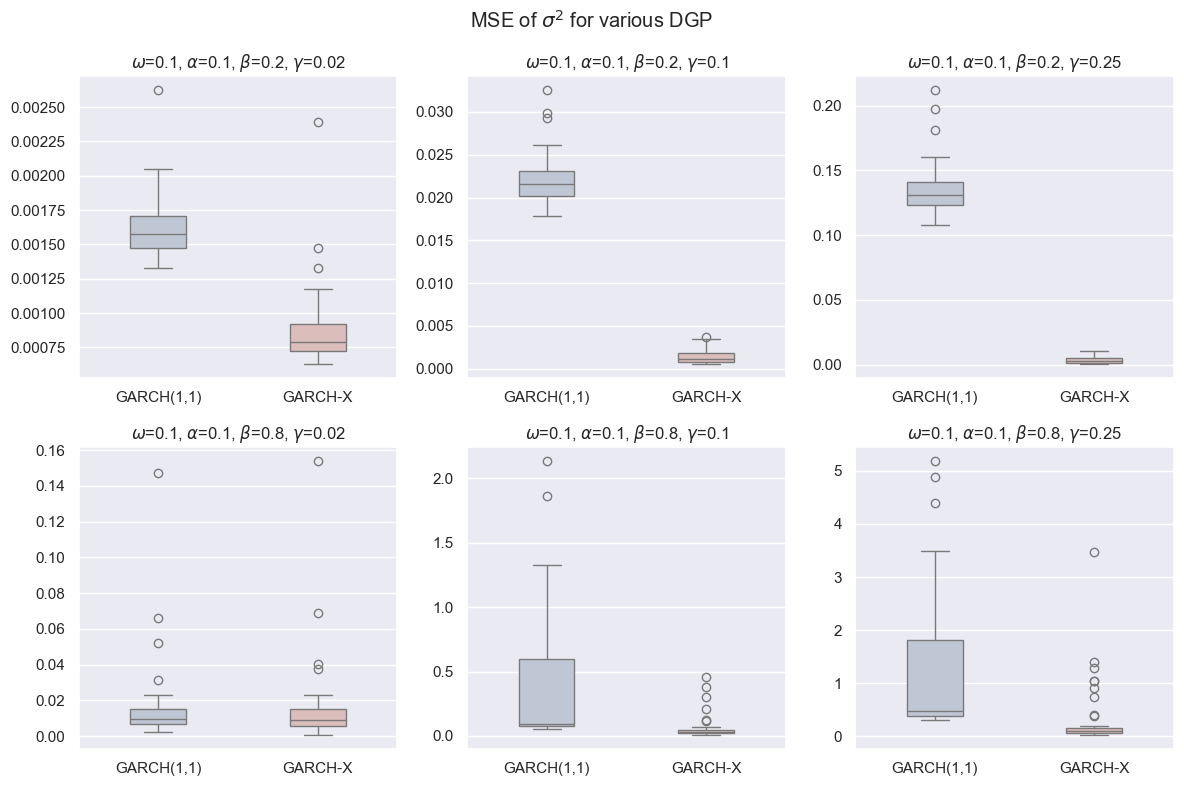

In [206]:
r = 3
f, axs = plt.subplots(2, r, figsize=(12,8))
f.suptitle(r"MSE of $\sigma^2$ for various DGP")

for i, params in enumerate(itertools.product(omegas, alphas, betas, gammas)):
    omega, alpha, beta, gamma = params

    filtered_df = result_df.loc[(result_df['omega'] == omega) & (result_df['alpha'] == alpha) & 
                                (result_df['beta'] == beta) & (result_df['gamma'] == gamma) & (result_df['without_exo_opt_suc']), 
                                ['without_exo_MSE', 'with_exo_MSE']]

    sns.boxplot(filtered_df, ax=axs[i//r][i%r],  width=.35, palette="vlag")

    axs[i//r][i%r].set_xticklabels(['GARCH(1,1)', 'GARCH-X'])
    axs[i//r][i%r].title.set_text(fr"$\omega$={omega}, $\alpha$={alpha}, $\beta$={beta}, $\gamma$={gamma}")

f.tight_layout()

### b\) Compare log likelihood values.
Note that we drop rows where either model failed to optimise successfully.

In [207]:
# Compare mean MSE
ll_df = result_df.groupby(by=['omega', 'alpha', 'beta', 'gamma']).agg({'without_exo_logll': ['mean'], 'with_exo_logll': ['mean']})
ll_df

without_exo_logll with_exo_logll
                                    mean           mean
omega alpha beta gamma                                 
0.1   0.1   0.2  0.02        -640.748866    -633.248684
                 0.10        -942.167978    -887.226867
                 0.25       -1272.714895   -1159.465526
            0.8  0.02       -1786.711269   -1785.805682
                 0.10       -4889.154166   -4844.309678
                 0.25       -5213.021544   -5172.045492

C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\2997442428.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//r][i%r].set_xticklabels(['GARCH(1,1)', 'GARCH-X'])
C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\2997442428.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//r][i%r].set_xticklabels(['GARCH(1,1)', 'GARCH-X'])
C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\2997442428.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//r][i%r].set_xticklabels(['GARCH(1,1)', 'GARCH-X'])
C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\2997442428.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i//r][i%r].set_xticklabels

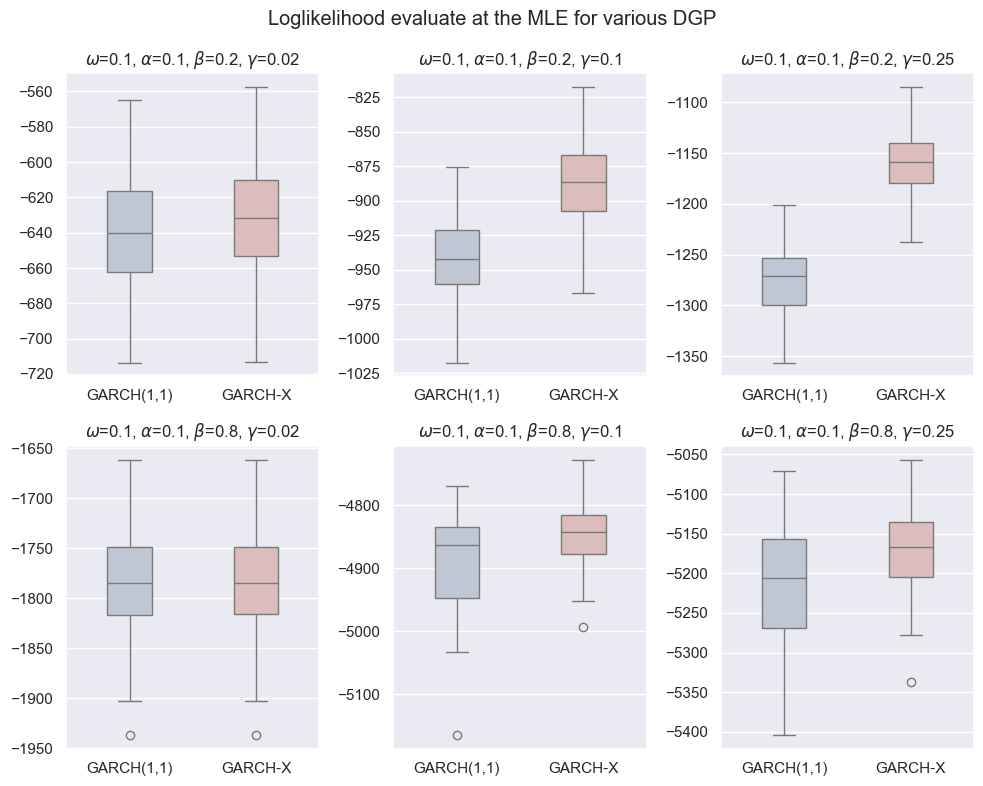

In [208]:
r = 3
f, axs = plt.subplots(2, r, figsize=(10,8))
f.suptitle(r"Loglikelihood evaluate at the MLE for various DGP")
for i, params in enumerate(itertools.product(omegas, alphas, betas, gammas)):

    omega, alpha, beta, gamma = params

    filtered_df = result_df.loc[(result_df['omega'] == omega) & (result_df['alpha'] == alpha) & 
                                (result_df['beta'] == beta) & (result_df['gamma'] == gamma) & (result_df['without_exo_opt_suc']), 
                                ['without_exo_logll', 'with_exo_logll']]
    
    #filtered_df = filtered_df.loc[filtered_df['without_exo_logll'] > -6500]  # Remove outlier

    sns.boxplot(filtered_df, ax=axs[i//r][i%r],  width=.35, palette="vlag")

    axs[i//r][i%r].set_xticklabels(['GARCH(1,1)', 'GARCH-X'])
    axs[i//r][i%r].title.set_text(fr"$\omega$={omega}, $\alpha$={alpha}, $\beta$={beta}, $\gamma$={gamma}")

f.tight_layout()

### c) Check convergence of estimated parameters

In [ ]:
param_agg = {}
for param in ['omega', 'alpha', 'beta', 'gamma']:
    param_agg[param + '_with_exo'] = 'std'
    if param == 'gamma':
        continue
    param_agg[param + '_wo_exo'] = 'std'

param_df = result_df.groupby(by=['omega', 'alpha', 'beta', 'gamma']).agg(param_agg)

In [ ]:
param_df

omega_with_exo  omega_wo_exo  alpha_with_exo  \
omega alpha beta gamma                                                 
0.1   0.1   0.2  0.02         0.024436      0.022337        0.034923   
                 0.10         0.017968      0.051188        0.034820   
                 0.25         0.019944      0.094907        0.032859   
            0.8  0.02         0.050251      0.049859        0.029535   
                 0.10         0.063283      0.125370        0.034012   
                 0.25         0.076211      0.205179        0.032368   

                        alpha_wo_exo  beta_with_exo  beta_wo_exo  \
omega alpha beta gamma                                             
0.1   0.1   0.2  0.02       0.038021       0.162302     0.135365   
                 0.10       0.046182       0.083123     0.191821   
                 0.25       0.053743       0.059735     0.203676   
            0.8  0.02       0.029069       0.057242     0.058641   
                 0.10       0.101598       0.058808     0.083389   
                 0.25       0.093878       0.055923     0.067089   

                        gamma_with_exo  
omega alpha beta gamma                  
0.1   0.1   0.2  0.02         0.006215  
                 0.10         0.012595  
                 0.25         0.023336  
            0.8  0.02         0.015950  
                 0.10         0.035539  
                 0.25         0.085256

C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\605933744.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, f'{param}_with_exo_diff'] = filtered_df[f'{param}_with_exo'] - filtered_df[param]
C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\605933744.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, f'{param}_wo_exo_diff'] = filtered_df[f'{param}_wo_exo'] - filtered_df[param]
C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_5552\605933744.py:12: SettingWithCopyWar

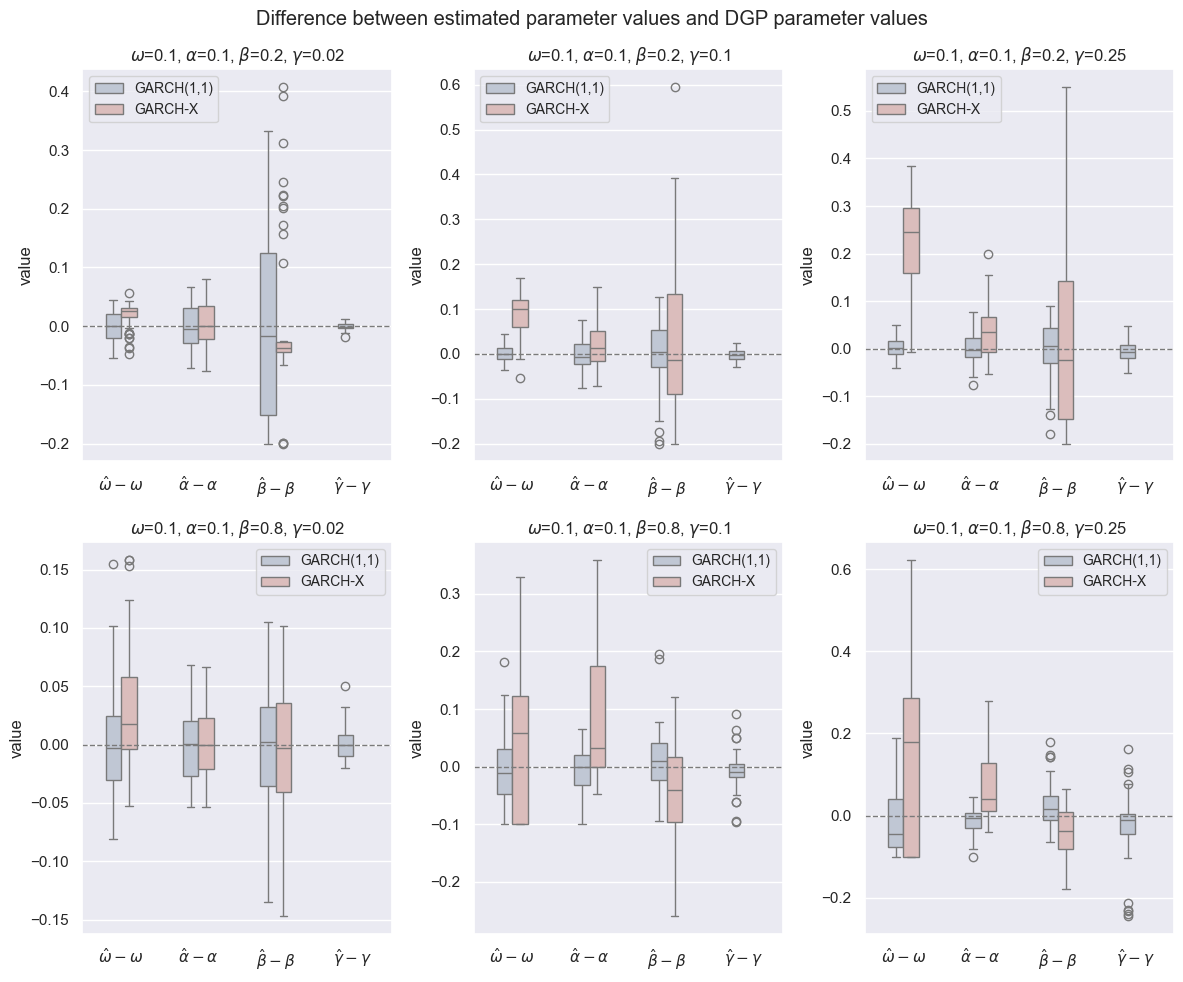

In [222]:
r = 3
f, axs = plt.subplots(2, r, figsize=(12,10))
f.suptitle(r"Difference between estimated parameter values and DGP parameter values")
for i, params in enumerate(itertools.product(omegas, alphas, betas, gammas)):

    omega, alpha, beta, gamma = params

    filtered_df = result_df.loc[(result_df['omega'] == omega) & (result_df['alpha'] == alpha) & 
                                (result_df['beta'] == beta) & (result_df['gamma'] == gamma) & (result_df['without_exo_opt_suc'])]

    for param in ['omega', 'alpha', 'beta', 'gamma']:
        filtered_df.loc[:, f'{param}_with_exo_diff'] = filtered_df[f'{param}_with_exo'] - filtered_df[param]
        if param == 'gamma':
            continue
        filtered_df.loc[:, f'{param}_wo_exo_diff'] = filtered_df[f'{param}_wo_exo'] - filtered_df[param]

        # Melt the DataFrame to long format
    df_long = filtered_df[['omega_with_exo_diff', 'omega_wo_exo_diff',
        'alpha_with_exo_diff', 'alpha_wo_exo_diff', 'beta_with_exo_diff',
        'beta_wo_exo_diff', 'gamma_with_exo_diff']].melt(var_name='parameter', value_name='value')

    # Extract the type (omega, alpha, beta, gamma) and whether it is 'with' or 'wo'
    df_long[''] = df_long['parameter'].str.extract(r'^(omega|alpha|beta|gamma)')
    df_long['Model'] = df_long['parameter'].str.contains('with').map({True: 'GARCH(1,1)', False: 'GARCH-X'})

    sns.boxplot(data=df_long, x='', y='value', hue='Model', ax=axs[i//r][i%r],  width=.4, palette="vlag")
    axs[i//r][i%r].axhline(y=0, color="#7A7A7A", linestyle='--', linewidth=1)

    axs[i//r][i%r].set_xticklabels([r'$\hat{\omega}-\omega$', r'$\hat{\alpha}-\alpha$', r'$\hat{\beta}-\beta$', r'$\hat{\gamma}-\gamma$'])
    axs[i//r][i%r].title.set_text(fr"$\omega$={omega}, $\alpha$={alpha}, $\beta$={beta}, $\gamma$={gamma}")
    axs[i//r][i%r].legend(fontsize=10)


f.tight_layout()

In [47]:
result_df.groupby(by=['omega', 'alpha', 'beta', 'gamma']).agg({'without_exo_MSE': 'mean', 'with_exo_MSE': 'mean'})

without_exo_MSE  with_exo_MSE
omega alpha beta gamma                               
0.1   0.1   0.2  0.01          0.001529      0.000867
                 0.10          0.076185      0.002342
                 0.25          0.478579      0.007806
            0.8  0.01          0.015677      0.015419
                 0.10          0.926426      0.136372
                 0.25          4.889689      0.546971